In [105]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import MCPhaseGate, MCXGate
from IPython.display import display, Markdown, Latex
import random 
import numpy as np

In [106]:
# We will need these throughout the notebook 
def quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    QFT_circuit = QuantumCircuit(quantum_register, name=f"QFT")

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        QFT_circuit.swap(q, p)

    for i, q in enumerate(quantum_register, start=1):
        QFT_circuit.h(q)
        for j, p in enumerate(quantum_register[i:], start=1):
            QFT_circuit.cp(np.pi / (1 << j), q, p)

    return QFT_circuit

def inverse_quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    inverse_QFT_circuit = QuantumCircuit(quantum_register, name=f"IQFT")

    for i, q in enumerate(reversed(quantum_register), start=1):
        for j, p in enumerate(reversed(quantum_register[n + 1 - i:]), start=1):
            inverse_QFT_circuit.cp(- np.pi / (1 << (i - j)), q, p)
        inverse_QFT_circuit.h(q)

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        inverse_QFT_circuit.swap(q, p)

    return inverse_QFT_circuit


def evaln(f,n,args):
    output = 0
    for key in f:
        monoargs = []
        for i in range(len(key)):
            if key[i] == '1':
                monoargs.append(args[i])
        output += f[key] * np.prod(monoargs)
    return output



"Grover Adaptive Search for Constrained Polynomial Binary Optimization” (Following Gilliam-Woerner-Gonciulea)

Task: given a function $f: \mathbb{F}^{n}_{2} \rightarrow \mathbb{Z}$, a threshold $t \in \mathbb{Z}$ and a  constraint function $ C: \mathbb{F}^{n}_{2} \rightarrow \mathbb{Z}$ construct an oracle/marker circuit $U_{f,t,C}$ such that 

$$
U_{f,t,C} | x \rangle_{n} | y \rangle_{1} =
\begin{cases}
| x \rangle_{n} | y \oplus 1 \rangle_{1},  \text{ if } f(x) \geq t \text{ and } C(x) \geq 0 \\
| x \rangle_{n} | y \rangle_{1} , \text{ otherwise}\\
\end{cases}
$$

We assume that we are given polynomial functions $f: \mathbb{F}_{2}^{n} \rightarrow \mathbb{Z}$ and $C: \mathbb{F}_{2}^{n} \rightarrow \mathbb{Z}$ encoded as dictionaries (of coefficients) $f$ and $C$, with keys given by bitstrings $b_{0} b_{1} \cdots b_{n-1}$ representing monomials $x_{0}^{b_{0}} x_{1}^{b_{1}} \cdots x_{n-1}^{b_{n-1}}$, and corresponding values $f[key] \in \mathbb{Z}$ representing the coefficient of a respective monomial $x_{0}^{b_{0}} x_{1}^{b_{1}} \cdots x_{n-1}^{b_{n-1}}$. 

Furthermore, we suppose that we are also provided with a fixed integer $t \in \mathbb{Z}$. Note that the condition that $f(x) \geq t$ is the same as $f(x) - t \geq 0$. We will use the notation $f_{t} := f - t$. 


Once $f$, $C$ and $t$ are given, we (roughly) calculate an upper bound on the number of (qu)bits required to encode the possible outputs $f(x_{0}, x_{1}, \cdots, x_{n-1}) - t$ and $C(x_{0}, x_{1}, \cdots, x_{n-1})$. Throughout this notebook, this value will be referred to as $m$.  

We may use the random module to generate examples for $f_{t}$, $C$ and $t$:

In [107]:

def input_generator(n, seed, t):
    f = dict.fromkeys( [ bin(x)[2:].zfill(n)  for x in range(0, 2**(n)  ) ], 0)
    ft_bound = 0

    for key in f:
        value = random.randint(-seed,seed)
        ft_bound += abs(value)
        f[key] = value
    f_t = f     
    f_t['0'*n] = -t
    ft_bound += f_t['0'*n]
    
    
    C_bound = 0 
    C = dict.fromkeys( [ bin(x)[2:].zfill(n)  for x in range(0, 2**(n)  ) ], 0)
    for key in C:
        valueC = random.randint(-seed,seed)
        C_bound += abs(value)
        C[key] = valueC
        
    m = max(ft_bound.bit_length(), C_bound.bit_length()) + 1 # Number of output bits needed to represent the function values
    return f_t, C, m

In [108]:
t = random.randint(-7,7)
f_t, C, m = input_generator(3,7, t)

f = f_t.copy()
f['000'] = f_t['000'] + t


print('For example, the dictionary') 
print(f) 
print('represents the monomials:')

for key in f:
    display(Markdown(f'{f[key]} $x_{2}^{key[0]} x_{1}^{key[1]} x_{0}^{key[2]}$'))

display(Markdown("Note that the exponents are assigned to the monomials in order of bits in little-endian format"))

For example, the dictionary
{'000': 0, '001': -1, '010': 1, '011': -3, '100': 3, '101': 3, '110': -2, '111': -4}
represents the monomials:


0 $x_2^0 x_1^0 x_0^0$

-1 $x_2^0 x_1^0 x_0^1$

1 $x_2^0 x_1^1 x_0^0$

-3 $x_2^0 x_1^1 x_0^1$

3 $x_2^1 x_1^0 x_0^0$

3 $x_2^1 x_1^0 x_0^1$

-2 $x_2^1 x_1^1 x_0^0$

-4 $x_2^1 x_1^1 x_0^1$

Note that the exponents are assigned to the monomials in order of bits in little-endian format


Following the G-W-G paper, we construct an operator $A$ such that, given a polynomial $P$ we get:

$$
A | x \rangle_{n} | 0 \rangle_{m} = | x \rangle_{n} | P(x) \rangle_{m}
$$

so that for  $s = \frac{1}{\sqrt{n}} \sum\limits_{x \in \mathbb{F}^{n}_{2} } | x \rangle_{n}$, we get $
A | s \rangle _{n} | 0 \rangle_{m} =  \frac{1}{\sqrt{n}} \sum\limits_{x \in \mathbb{F}_{2}^{n}} | x \rangle_{n} | P(x) \rangle_{m}$




The right-hand sum is an equal superposition of all inputs $x \in \mathbb{F}^{n}_{2}$ in the first $n$-bits (the input register) and their corresponding outputs $P(x)$ encoded in the last $m$-bits (the output register). Here, we assume that the outputs $P(x)$ can be encoded with $m$ bits.

The below code is essentially a multi-controlled "Draper adder" circuit. Given an input $x \in \mathbb{F}^{n}_{2}$, the output $P(x) \in \mathbb{Z}$ can be encoded as a binary sequence given by the $m$-bit binary expansion of the integer $P(x)$. 

Furthermore, the binary sequence $b_{1} b_{2} \cdots b_{m}$ represents $P(x)$ modulo $2^{m}$ -- which means if $P(x)$ is negative, then $2^{m} + P(x) \equiv_{2^{m}} P(x)$ has $1$ as the most significant digit. It is easy to see that $b_{1} b_{2} \cdots b_{m}$ will have $1$ as the most significant digit iff $P(x) < 0$. 

Each bitstring $a = a_{0} \cdots a_{n-1}$ represents a valid input for the polynomial $P$. The output $P(a_{0}, \cdots, a_{n-1})$ is an integer which may be encoded in $m$ bits. It is computed by considering each monomial $P[``k_{0} \cdots k_{n-1} "] x_{0}^{k_{0}} x_{1}^{k_{1}} \cdots x_{n-1}^{k_{n-1}}$, for each key bitstring $``k_{0} \cdots k_{n-1}"$ in the dictionary $P$ encoding the coefficients of $P$, and evaluating $P[``k_{0} \cdots k_{n-1}"] a_{0} \cdots a_{n-1}$.

 Recall that Draper's circuit uses a combination of phaser gates corresponding to an integer $k$, so that $| 0 \rangle_{m} \mapsto | k \textnormal{ mod } 2^{m} \rangle_{m}$. The code below operates in the same way, but now with the input register as part of the system, we can perform controlled adder gates acting so that $ | x \rangle_{n} | 0 \rangle_{m} \mapsto | a_{0} \cdots a_{n-1} \rangle_{n} | P(a_{0}, \cdots, P_{n-1})  \rangle_{m}$ if $ | x \rangle_{n} =  | a_{0} \cdots a_{n-1} \rangle_{m}$ and  $| x \rangle_{n} | 0 \rangle_{m}$ otherwise. 


These "multi-controlled adder gates" are implemented by combining (arbitrary) multi-controlled gates which target some ancilla qubits, and single controlled phase gates which target a corresponding bit in the output register. 


In [109]:
def circuitA_constructor(P,n,m):
    input_register = QuantumRegister(size=n, name="input")
    output_register = QuantumRegister(size=m, name="output")
    anc_register = AncillaRegister(size=m, name="ancilla")
    
    circuitA = QuantumCircuit(input_register, output_register, anc_register, name="A")
    invQFT = inverse_quantum_fourier_transform(m).to_gate(label="invQFT")
    circuitA.h(output_register)  # Initialize output register in superposition
    
    #encoding the constant term onto the output register, essentially every output gets adjusted by this constant term
    for i in range(0,m):
        theta = (  2*np.pi / 2**(m) )*(P['0'*n]) 
        circuitA.p((2**(m-i-1))*theta, output_register[m-1-i])
    
    for key in P.keys():
        controls = [input_register[i] for i in range(n) if str(key)[i] == '1']
        theta = (  2*np.pi / 2**(m) )*(P[key]) 
        
                
        for i in range(0,m):
            if len(controls) != 0:
                circuitA.mcx(control_qubits=controls, target_qubit=anc_register[m-1-i])
                circuitA.cp((2**(m-1-i))*theta, anc_register[m-i-1], output_register[m-1-i])
                circuitA.mcx(control_qubits=controls, target_qubit=anc_register[m-1-i])
 
    circuitA.append(invQFT, output_register)
    return circuitA 



Using the corresponding operator $A$ constructed above for a polynomial $P$, we see that the state $| x \rangle_{n} | P(x)\rangle_{m}$ is so that the most significant bit of $P(x)$ is a $0$ if $P(x) \geq 0$, and a $1$ if $P(x)$ is negative. 

Therefore, implementing a bit flip marker is simple: check the most significant digit and flip the "oracle bit" $y$ according to if the siginificant digit is a $0$ or a $1$

In [110]:
def oracleCircuit_constructor(m):

    

    oracle_bit = QuantumRegister(size=1, name="oracle_bit")
    output_register = QuantumRegister(size=m, name="ouput")

    oracleCircuit = QuantumCircuit(output_register, oracle_bit, name="Oracle")

    oracleCircuit.x(output_register[m-1])
    oracleCircuit.cx(output_register[m-1], oracle_bit[0])
    oracleCircuit.x(output_register[m-1])
    return oracleCircuit


Combining the $A_{f_{t}}$ and $A_{C}$ operators, and the corresponding marking oracles, we can build the following circuit:

1. First, we apply the operator $A_{f_{t}}$ to the input, output and ancilla register "anc_register" (the sole purpose of the ancilla register here is to implement multi-controlled rotation gates only using multi-controlled $X$ gates and singly controlled phase gates)
2.  We compose the circuit with the marking oracle defined above, using the qubits given by the output register and an oracle qubit $y_{1}$ whose state will flip iff the most significant digit in the output register is a $0$.

3. Then, we apply the inverse gate to $A_{f_{t}}$, in order to uncompute the output and ancilla registers back to their respective initial state $ | 0 \rangle_{m}$.  Note that this does not affect the oracle qubit in register "y1_register". It is necessary the uncompute the output and ancilla registers back to their original state, as we will re-use the same registers next for the operator $A_{C}$, which essentially repeats the first two steps for $C$ instead of $f_{t}$.

4. We apply the operator $A_{C}$ to the input,output and ancilla register "anc_register". Followed by another instance of the marking oracle as above, but now we use the qubits given by the output register and a separate oracle qubit $y_{2}$

5. We use the qubit $y$ from "y_register" as a marker oracle qubit for the logical AND of the two conditions $f_{t}(x) \geq 0$ and $C(x) \geq 0$. That is, we apply a Toffoli/CCX gate with the control qubits set to be $y_{1}$ and $y_{2}$, and the target qubit set to be $y$. Recall that $f_{t}(x) \geq 0$ is equivalent to $f(x) \geq t$.

In [111]:


def CombinedMarkerCircuit_constructor(f_t, C, n, m):

    input_register = QuantumRegister(size=n, name="input")
    output_register = QuantumRegister(size=m, name="ouput")
    anc_register = AncillaRegister(size=m, name='anc')
    y1_register = AncillaRegister(size=1, name='Oracle bit = y1')
    y2_register = AncillaRegister(size=1, name='Oracle bit = y2')

    y_register =  QuantumRegister(size=1, name='Input Oracle bit = y')
    
    circuitA_ft = circuitA_constructor(f_t,n,m)
    circuitA_ft_dg = circuitA_ft.inverse()
    opA_ft = circuitA_ft.to_gate()
    opA_ft_dg = circuitA_ft_dg.to_gate()

    circuitA_C = circuitA_constructor(C,n,m)
    circuitA_C_dg = circuitA_C.inverse()
    opA_C = circuitA_C.to_gate()
    opA_C_dg = circuitA_C_dg.to_gate()

    oracleCircuit_y1 = oracleCircuit_constructor(m)
    oracleCircuit_y2 = oracleCircuit_constructor(m) 
    
    # Initialize the combined marker circuit    
    CombinedMarkerCircuit = QuantumCircuit(input_register, output_register, anc_register, y1_register, y2_register,y_register, name="CombinedMarkerCircuit")

    #Marking the condition f(x) > t, using y1 as a marker oracle qubit 
    CombinedMarkerCircuit.compose(opA_ft, qubits=input_register[:] + output_register[:] + anc_register[:], inplace=True)
    CombinedMarkerCircuit.compose(oracleCircuit_y1, qubits=output_register[:] + y1_register[:], inplace=True) 
    CombinedMarkerCircuit.compose(opA_ft_dg , qubits=input_register[:] + output_register[:] + anc_register[:], inplace=True) 
    # we uncompute the output and anc registers to repeat the same process for C



    #Marking the condition C(x) > 0, using y2 as a marker oracle qubit 
    CombinedMarkerCircuit.compose(opA_C, qubits=input_register[:] + output_register[:] + anc_register[:], inplace=True)
    CombinedMarkerCircuit.compose(oracleCircuit_y2, qubits=output_register[:] + y2_register[:], inplace=True) 
    CombinedMarkerCircuit.compose(opA_C_dg, qubits=input_register[:] + output_register[:] + anc_register[:], inplace=True)


    # We can now consider y as a marker oracle qubit by applying a Toffoli/CCX gate which will flip the state of y if both y1 and y2 are in the |1> state.
    CombinedMarkerCircuit.barrier()
    CombinedMarkerCircuit.ccx(y1_register[0], y2_register[0], y_register[0])
    CombinedMarkerCircuit.barrier()

    # We uncompute all registers apart from the input register and the register containing the oracle bit y 
    # This is done to clean up the output state of the circuit. 
    CombinedMarkerCircuit.compose(opA_C, qubits=input_register[:] + output_register[:] + anc_register[:], inplace=True)
    CombinedMarkerCircuit.compose(oracleCircuit_y2, qubits=output_register[:] + y2_register[:], inplace=True) 
    CombinedMarkerCircuit.compose(opA_C_dg, qubits=input_register[:] + output_register[:] + anc_register[:], inplace=True)
    

    CombinedMarkerCircuit.compose(opA_ft, qubits=input_register[:] + output_register[:] + anc_register[:], inplace=True)
    CombinedMarkerCircuit.compose(oracleCircuit_y1, qubits=output_register[:] + y1_register[:], inplace=True) 
    CombinedMarkerCircuit.compose(opA_ft_dg , qubits=input_register[:] + output_register[:] + anc_register[:], inplace=True) 

    return CombinedMarkerCircuit

In [112]:

def Stateprep_constructor(n, m):

    input_register = QuantumRegister(size=n, name="input")
    output_register = QuantumRegister(size=m, name="ouput")
    anc_register = AncillaRegister(size=m, name='anc')
    y1_register = AncillaRegister(size=1, name='Oracle bit = y1')
    y2_register = AncillaRegister(size=1, name='Oracle bit = y2')

    y_register =  QuantumRegister(size=1, name='Input Oracle bit = y')
    
    stateprepCircuit = QuantumCircuit(input_register, output_register, anc_register, y1_register, y2_register,y_register, name="StateprepCircuit")
    stateprepCircuit.h(input_register)
    return stateprepCircuit
    

<b><ins> Preliminary complexity analysis </ins></b>

Let us give a brief description of some of the complexities involved with the above constructions. We will fix the size of the output register to be $m$, and consider the resource and space requirements as a function of the size of the input register, $n$.

For the circuit $A_{P}$, given a polynomial $P: \mathbb{F}^{n}_{2} \rightarrow \mathbb{Z}$, we use the gates:

| Gate  |  | Count, upper bound |
| --- | --- | --- |
| H |       | $m$ |
| MCX |     | $n + \binom{n}{2} + \cdots + \binom{n}{n-1} + \binom{n}{n} = 2^{n} - 1$ | 
|  Controlled phase, cp |     |  $m \cdot (2^{n} - 1 )$  |
| Inverse QFT |    | 1 |


Therefore, the gate count is in $\mathcal{O}( 2^{n} )$. As for circuit depth, we note that the depth of the circuit as a function of $n$, is also in $\mathcal{O}( 2^{n} )$. Note that $n + \binom{n}{2} + \cdots + \binom{n}{n-1} + \binom{n}{n}  = 2^{n} - 1$ is the number of possible monomials over $\mathbb{F}^{n}_{2}$ with non-zero degree. 

At worst, we may have a polynomial such that a certain variable $x_{i}$ appears in every (non-zero) monomial appearing in the decomposition of $P$ into homogeneous terms. Then, we see that the depth of the circuit is bounded above by $3 \times m \times (2^{n} - 1) + \mathcal{O}(1)$.

Ancilla qubits required are $1$ for each qubit required for the output register. That is, if outputs for $P$ can be encoded with $m$ bits, then we will need $m$ ancilla qubits. This is independent of $n$.


The marking oracle circuit which checks the significant digit in the output register uses $2$ X-gates (to flip the condition from negative to positive, recall that negative outputs have a $1$ as the sigificant digit), and it also uses a single CX gate. Both of these gate counts are independent of $n$, and so does not contribute to the dominanting complexity as $n \to \infty$. The same holds for the depth of these circuit -- it is independent of $n$. 



Therefore, the overall gate count and circuit depth for the complete "combined marking circuit" implementing $U_{f,t,C}$, as a function of $n$, is in $\mathcal{O}(2^{n})$



However, note that if there is an upper bound $D < n$ on the degrees of the polynomials given by $f$ and $C$, then the overall gate and depth counts, as functions of $n$, are in $\mathcal{O} \big( n + \binom{n}{2} + \cdots + \binom{n}{D} \big)$.








<b> <ins> Testing </ins> </b>

Every example of $f$, $C$ and $m$ appearing below was generated using the "input_generator" function defined above, although of course one can plug in coefficients by hand as well.

We test the above circuits for $n = 2$ and $t = -6$. We fix an example $f$ and $C$ as inputs and calculate the required $m$ below:

In [113]:

n  = 2
t = -6

f_t = {'00': 6, '01': -2, '10': -7, '11': 4}

f = f_t.copy()
f['00']  = f_t['00'] + t 

C = {'00': 5, '01': 5, '10': 0, '11': -2}
m = 6


We prepare the Hadamard-superposition state $ | s \rangle_{n} =  \frac{1}{\sqrt{n}} \sum_{x \in \mathbb{F}_{2}^{n}} | x \rangle_{n}$ to be passed through the combined marker circuit as the input register. The expected result should be of the form 

$$
\frac{1}{\sqrt{n}} \sum\limits_{x \in \mathbb{F}_{2}^{n}}  | y 0 0 0 \cdots 0 x \rangle_{ n + 2m + 2 + 1} 
$$ 
where:
$$
y =  
\begin{cases}
1, \textnormal{ if $f(x) > t$ and $C(x) > 0$ } \\
0, \textnormal{else} 
\end{cases}
$$


In [114]:
qc = Stateprep_constructor(n, m)
CombinedMarkerCircuit = CombinedMarkerCircuit_constructor(f_t, C, n, m)



testqc = qc.compose(CombinedMarkerCircuit)
psi = Statevector(testqc)
psi.draw("Latex") 




<IPython.core.display.Latex object>

In the above example, we see that the combined condition holds for all inputs except $(1,0)$. Indeed, we look at all the outputs $f(x_{0},x_{1})$ and $C(x_{0}, x_{1})$ for all possible inputs $(x_{0}, x_{1})$. Recall one must read the ordering in reverse when going from the qubit ordering to input ordering.

In [115]:
for x in range(0,2):
    for y in range(0,2):
        print(f"f({x},{y}) = {evaln(f,n,[x,y])}" + " and " + f"C({x},{y}) = {evaln(C,n,[x,y])}")


f(0,0) = 0.0 and C(0,0) = 5.0
f(0,1) = -2.0 and C(0,1) = 10.0
f(1,0) = -7.0 and C(1,0) = 5.0
f(1,1) = -5.0 and C(1,1) = 8.0


From the above output, we see that only $(1,0) \in \mathbb{F}_{2}^{n}$ does not satisfy the condition. This is why $| 0 0 0 \cdots 0 1 \rangle$ is the only state in the above superposition without a $|1 \rangle$ as the left most qubit state (i.e. the oracle bit state). In fact, let us prepare the initial state $| 0 0 0 \cdots 0 1 \rangle$ and show that the circuit does not flip the oracle bit.

In [116]:

qctest = QuantumCircuit(CombinedMarkerCircuit.num_qubits)
qctest.x(0) 

psi = Statevector(qctest.compose(CombinedMarkerCircuit))

psi.draw("Latex")  

<IPython.core.display.Latex object>

On the other hand, starting from the $0$ state, we should get $ |1 0 0 0 \cdots 0 \rangle$. 

In [117]:

qctest = QuantumCircuit(CombinedMarkerCircuit.num_qubits)

psi = Statevector(qctest.compose(CombinedMarkerCircuit))

psi.draw("Latex")  

<IPython.core.display.Latex object>

As expected..

Let's try another example, with $t = 3$ and $n = 2$.



In [118]:

n = 2 
f_t = {'00': -3, '01': 4, '10': 7, '11': -3}
C = {'00': 1, '01': -2, '10': 0, '11': 3}
m = 5 
f = f_t.copy()
f['00']  = f_t['00'] + 3



In [119]:
qc = Stateprep_constructor(n, m)
CombinedMarkerCircuit = CombinedMarkerCircuit_constructor(f_t, C, n, m)

In [120]:
testqc = qc.compose(CombinedMarkerCircuit)
psi = Statevector(testqc)
psi.draw("Latex")  


<IPython.core.display.Latex object>

In this example, input vectors that satisfy both conditions are $(x_{0}, x_{1}) = (1,0)$ and $(x_{0}, x_{1}) = (1,1)$

In [121]:
for x in range(0,2):
    for y in range(0,2):
        print(f"f({x},{y}) = {evaln(f,n,[x,y])}" + " and " + f"C({x},{y}) = {evaln(C,n,[x,y])}")

f(0,0) = 0.0 and C(0,0) = 1.0
f(0,1) = 4.0 and C(0,1) = -1.0
f(1,0) = 7.0 and C(1,0) = 1.0
f(1,1) = 8.0 and C(1,1) = 2.0


Even though $f(0,0) \geq 0$ and $C(0,0) \geq 0$, the $0$ state does not get affected by the marking oracle because the threshold is set to $t = 3$. 

In [122]:
qctest = QuantumCircuit(CombinedMarkerCircuit.num_qubits)
psi = Statevector(qctest.compose(CombinedMarkerCircuit))

psi.draw("Latex")  

<IPython.core.display.Latex object>

Just to check, we can also initialize the inital input state to $ | 0 \cdots 0 1 \rangle$. Again, as $(1,0)$ is a valid input, the marking oracle will flip the state of the oracle qubit $| 0 \rangle$ to $ | 1 \rangle$.

In [123]:
qctest = QuantumCircuit(CombinedMarkerCircuit.num_qubits)
qctest.x(0)
psi = Statevector(qctest.compose(CombinedMarkerCircuit))

psi.draw("Latex")  

<IPython.core.display.Latex object>

Now, we run an example with $n = 3$, $t = 2$

In [124]:
n = 3

f_t = {'000': -2, '001': -2, '010': 0, '011': 0, '100': -5, '101': 1, '110': 7, '111': 5}
C = {'000': 1, '001': 6, '010': 6, '011': -7, '100': -2, '101': -4, '110': -1, '111': 5}
m = 7 


f = f_t.copy()
f['000']  = f_t['000'] + 2


In [125]:
qc = Stateprep_constructor(n, m)
CombinedMarkerCircuit = CombinedMarkerCircuit_constructor(f_t, C, n, m)

psi = Statevector(qc.compose(CombinedMarkerCircuit))
psi.draw("Latex") 

<IPython.core.display.Latex object>

According to the above state, we see that the only inputs that satisfy both $f(x) \geq 2$ and $C(x) \geq 0$ should be $x = (1,1,1)$ and $x = (1,1,0)$

Enumerating through all possible inputs and outs for $f$ and $C$, we get:

In [126]:
for x in range(0,2):
    for y in range(0,2):
        for z in range(0,2):
            print(f"f({x},{y},{z}) = {evaln(f,n,[x,y,z])}" + " and " + f"C({x},{y},{z}) = {evaln(C,n,[x,y,z])}")

f(0,0,0) = 0.0 and C(0,0,0) = 1.0
f(0,0,1) = -2.0 and C(0,0,1) = 7.0
f(0,1,0) = 0.0 and C(0,1,0) = 7.0
f(0,1,1) = -2.0 and C(0,1,1) = 6.0
f(1,0,0) = -5.0 and C(1,0,0) = -1.0
f(1,0,1) = -6.0 and C(1,0,1) = 1.0
f(1,1,0) = 2.0 and C(1,1,0) = 4.0
f(1,1,1) = 6.0 and C(1,1,1) = 4.0


...which confirms the above findings.

Again, we may independently check the effect of passing in the state $ | 1 1 1 \rangle$ for the initial input state (with oracle bit $y = 0$):

In [127]:
qctest = QuantumCircuit(CombinedMarkerCircuit.num_qubits)
qctest.x([0,1,2])
psi = Statevector(qctest.compose(CombinedMarkerCircuit))

psi.draw("Latex")  

<IPython.core.display.Latex object>

Finally, we run an example where $n = 4$ but functions are quadratic. We set $t = 3$

The below encodes 
$$
f = x_{3} + 3 x_{0} x_{1} + 2 x_{1} x_{2} + x_{2} x_{3} + x_{0} 
$$

$$
C = x_{0} + x_{2}x_{3} - x_{1} + 2 x_{2} 
$$

In [128]:
n = 4
t = 3

f_t = {'0000': -3, '1000': 1, '0011': 3, '0110': 2, '1100': 1, '1111': 0, '0001': 1, '0010': 0, '0100': 0, '1010': 0, '1101': 0, '1110': 0}
C = {'0001': 1, '1100': 1, '1111': 0, '0000': 0, '0010': -1, '0100': 2, '1000': 0, '1010': 0, '1101': 0, '1110': 0}

f = f_t.copy()
f['0000']  = f_t['0000'] + t 

m = 3

In [129]:
qc = Stateprep_constructor(n, m)
CombinedMarkerCircuit = CombinedMarkerCircuit_constructor(f_t, C, n, m)



testqc = qc.compose(CombinedMarkerCircuit)
psi = Statevector(testqc)
psi.draw("Latex")  

<IPython.core.display.Latex object>

Recall that we must read the input bitstrings in little-endian format. So, we should have that the inputs that satisfy both conditions are
$(x_{0},x_{1}, x_{2}, x_{3}) = (1,1,1,0)$, $(1,1,1,1)$, $(1,0,1,1)$ and $(0,0,1,1)$, $(0,1,1,1)$. 


Initialize input state to $x = (0,1,1,1)$   (and oracle bit $y = 0$) 

In [130]:
qctest = QuantumCircuit(CombinedMarkerCircuit.num_qubits)
qctest.x([0,1,2])
psi = Statevector(qctest.compose(CombinedMarkerCircuit))

psi.draw("Latex")  

<IPython.core.display.Latex object>

Again, we can classically check our answers:

In [131]:
for x in range(0,2):
    for y in range(0,2):
        for z in range(0,2):
            for w in range(0,2):
                print(f"f({x},{y},{z},{w}) = {evaln(f,n,[x,y,z,w])}" + " and " + f"C({x},{y},{z},{w}) = {evaln(C,n,[x,y,z,w])}")

f(0,0,0,0) = 0.0 and C(0,0,0,0) = 0.0
f(0,0,0,1) = 1.0 and C(0,0,0,1) = 1.0
f(0,0,1,0) = 0.0 and C(0,0,1,0) = -1.0
f(0,0,1,1) = 4.0 and C(0,0,1,1) = 0.0
f(0,1,0,0) = 0.0 and C(0,1,0,0) = 2.0
f(0,1,0,1) = 1.0 and C(0,1,0,1) = 3.0
f(0,1,1,0) = 2.0 and C(0,1,1,0) = 1.0
f(0,1,1,1) = 6.0 and C(0,1,1,1) = 2.0
f(1,0,0,0) = 1.0 and C(1,0,0,0) = 0.0
f(1,0,0,1) = 2.0 and C(1,0,0,1) = 1.0
f(1,0,1,0) = 1.0 and C(1,0,1,0) = -1.0
f(1,0,1,1) = 5.0 and C(1,0,1,1) = 0.0
f(1,1,0,0) = 2.0 and C(1,1,0,0) = 3.0
f(1,1,0,1) = 3.0 and C(1,1,0,1) = 4.0
f(1,1,1,0) = 4.0 and C(1,1,1,0) = 2.0
f(1,1,1,1) = 8.0 and C(1,1,1,1) = 3.0


<b> <ins> Circuit diagrams </ins> </b> 


Combined oracle circuit:

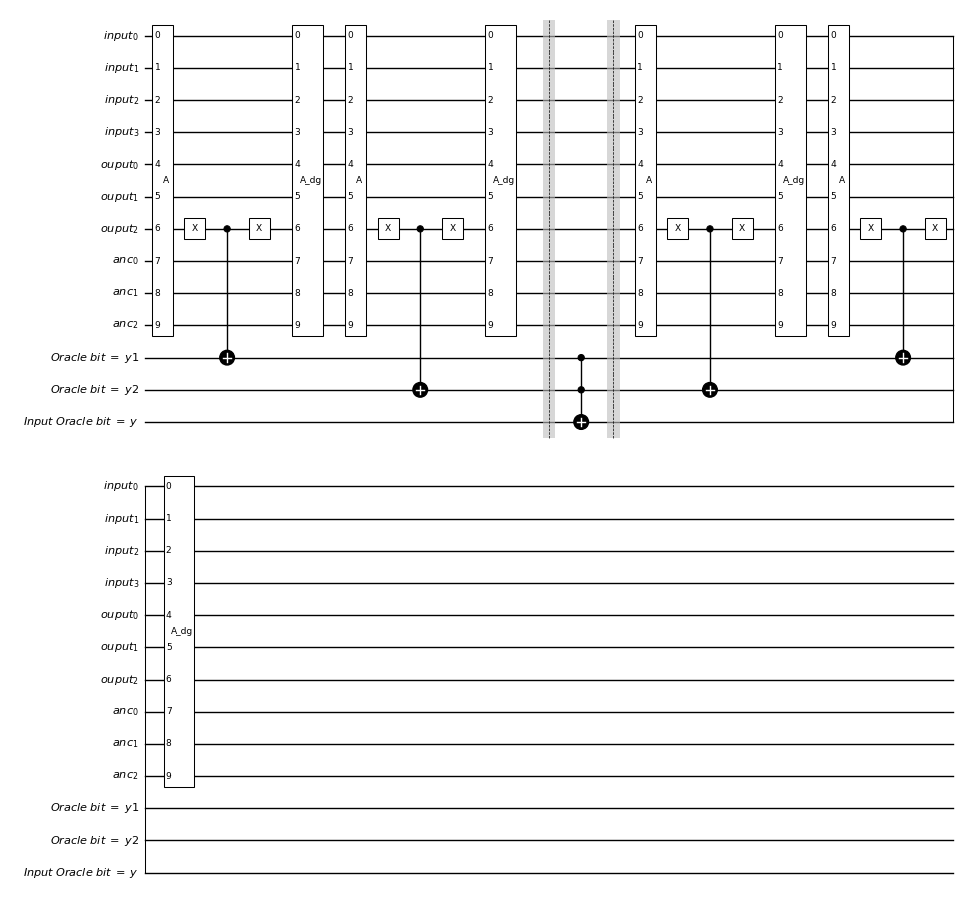

In [132]:
CombinedMarkerCircuit.draw("mpl", scale=0.5, style="bw")

Circuit corresponding to the operator $A_{f_{t}}$:

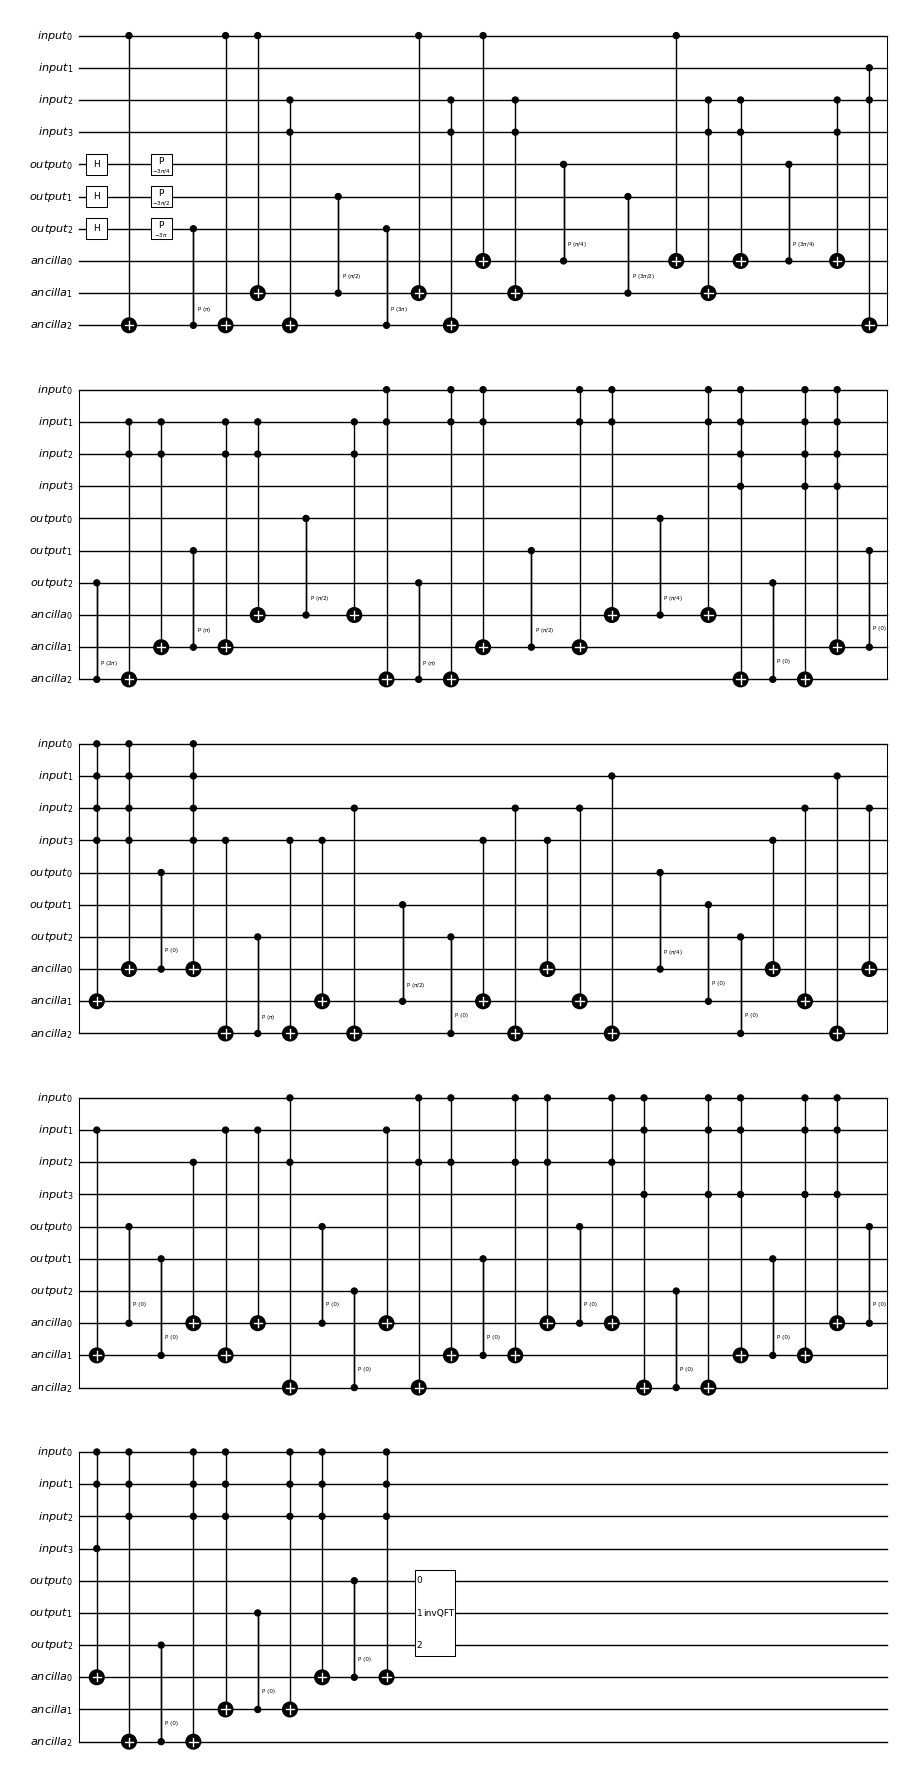

In [133]:
circuitA_ft = circuitA_constructor(f_t,n,m)
circuitA_ft.draw("mpl", scale=0.5, style="bw")